In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import os
import pickle
import tqdm
import numpy
from scipy import interpolate
import healpy
import gaia_tools.load, gaia_tools.select
from galpy.util import bovy_plot, bovy_coords, save_pickles, multi
import mwdust
import effsel
from effsel import main_sequence_cut_r, giant_sequence_cut
%pylab inline
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import NullFormatter, FuncFormatter, LogFormatter
from matplotlib.colors import LogNorm
from matplotlib import gridspec
save_figures= False
numpy.random.seed(1)
nside= 2**5

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# The effective completeness of the *TGAS* CMD wrt *2MASS*

In [2]:
sp= effsel.load_spectral_types()
tgas= gaia_tools.load.tgas()
twomass= gaia_tools.load.twomass()
jk= twomass['j_mag']-twomass['k_mag']
dm= -5.*numpy.log10(tgas['parallax'])+10.
mj= twomass['j_mag']-dm

In [7]:
tsf= gaia_tools.select.tgasSelect()
tesf= gaia_tools.select.tgasEffectiveSelect(tsf,dmap3d=mwdust.Zero())
tesf_uniform= gaia_tools.select.tgasEffectiveSelect(gaia_tools.select.tgasSelectUniform(comp=1.))
tesf_ext= gaia_tools.select.tgasEffectiveSelect(tsf,dmap3d=mwdust.Combined15(filter='2MASS J'))

In [115]:
def twomass_selfunc(x,y,z,MJ,JK):
    """A function that returns 1 if a star is brighter than the 2MASS completeness limits in J and K, 0 otherwise"""
    out= numpy.zeros_like(x)
    # Need to compute distance
    dist= bovy_coords.XYZ_to_lbd(x.flatten(),y.flatten(),z.flatten())[:,2].reshape(x.shape)
    j= 5.*numpy.log(dist)+10.+MJ
    k= j-JK
    out[(j < 15.8)*(k < 14.3)]= 1.
    return out
def cyl_vol_func(X,Y,Z,xymin=0.,xymax=0.25,zmin=-0.05,zmax=0.05,use_cosh=False,cosh_zsun=0.):
    """A function that bins in cylindrical annuli around the Sun, optionally weights by 1/cosh^2"""
    xy= numpy.sqrt(X**2.+Y**2.)
    out= numpy.zeros_like(X)
    out[(xy >= xymin)*(xy < xymax)*(Z >= zmin)*(Z < zmax)]= 1.
    if use_cosh:
        out/= numpy.cosh((Z-cosh_zsun)/2./use_cosh)**2.
    return out
def cmd_completeness_one(MJ,JK,tesf,tesf_uniform,ndists=1001):
    if JK > 0.5: 
        cosh_zd= 0.15
        cosh_zsun= 0.025
    elif JK < 0.: 
        cosh_zd= 0.05
        cosh_zsun= 0.
    else:
        cosh_zd= 0.2*JK+0.05
        cosh_zsun= 0.
    tvol_func1= lambda x,y,z: cyl_vol_func(x,y,z,zmin=-0.05,zmax=0.05,use_cosh=cosh_zd)
    tvol_func2= lambda x,y,z: cyl_vol_func(x,y,z,xymax=0.5,zmin=-0.25,zmax=0.25,use_cosh=cosh_zd)
    evfs= tesf.volume(tvol_func1,MJ=MJ,JK=JK,ndists=ndists,xyz=True)
    evfs_2mass= tesf_uniform.volume(lambda x,y,z: twomass_selfunc(x,y,z,MJ,JK)*tvol_func1(x,y,z),
                                     ndists=ndists,xyz=True)
    evfs_wide= tesf.volume(tvol_func2,MJ=MJ,JK=JK,ndists=ndists,xyz=True)
    evfs_wide_2mass= tesf_uniform.volume(lambda x,y,z: twomass_selfunc(x,y,z,MJ,JK)*tvol_func2(x,y,z),
                                     ndists=ndists,xyz=True)
    return (evfs,evfs_2mass,evfs_wide,evfs_wide_2mass)
mjs= numpy.linspace(8.,-3.5,21)
jks= numpy.linspace(-0.1,1.,21)
ndists= 1001
savefilename= 'cmd_completeness.sav'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        evfs= pickle.load(savefile)
        evfs_2mass= pickle.load(savefile)
        evfs_wide= pickle.load(savefile)
        evfs_wide_2mass= pickle.load(savefile)
else:
    evfs= numpy.empty((len(mjs),len(jks)))
    evfs_2mass= numpy.empty((len(mjs),len(jks)))
    evfs_wide= numpy.empty((len(mjs),len(jks)))
    evfs_wide_2mass= numpy.empty((len(mjs),len(jks)))
    for ii in tqdm.tqdm(range(len(mjs))):
        multiOut= multi.parallel_map(lambda x: cmd_completeness_one(mjs[ii],jks[x],tesf,tesf_uniform,ndists=ndists),
                                     range(len(jks)),numcores=30)
        for jj in range(len(jks)):
            evfs[ii,jj]= multiOut[jj][0]
            evfs_2mass[ii,jj]= multiOut[jj][1]
            evfs_wide[ii,jj]= multiOut[jj][2]
            evfs_wide_2mass[ii,jj]= multiOut[jj][3]
    save_pickles(savefilename,evfs,evfs_2mass,evfs_wide,evfs_wide_2mass)

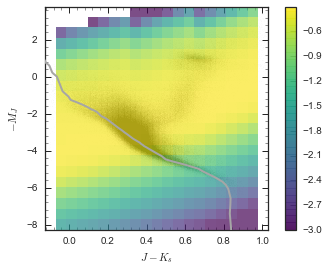

In [117]:
bovy_plot.bovy_dens2d(numpy.log10(evfs/evfs_2mass),origin='lower',cmap='viridis',
                     interpolation='nearest',zorder=1,
                     colorbar=True,vmin=-3.,vmax=numpy.log10(0.5),shrink=1.,alpha=0.7,
                     yrange=[-(mjs[0]-0.5*(mjs[1]-mjs[0])),
                            -(mjs[-1]+0.5*(mjs[1]-mjs[0]))],
                     xrange=[jks[0]-0.5*(jks[1]-jks[0]),
                             jks[-1]+0.5*(jks[1]-jks[0])],
                     xlabel=r'$J-K_s$',ylabel=r'$-M_J$')

def good_relplx(mj):
    out= numpy.empty_like(mj)
    out[mj > 5.]= 20.
    out[mj < 0.]= 10.
    out[(mj >= 0)*(mj <= 5.)]= 20.+2.*(mj[(mj >= 0)*(mj <= 5.)]-5.)
    return out
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
bovy_plot.bovy_plot((twomass['j_mag']-twomass['k_mag'])[good_plx_indx],
                    -(twomass['j_mag']-dm)[good_plx_indx],
                    'k,',rasterized=True,overplot=True,
                    xrange=[-0.5,1.5],yrange=[8.,-5.],alpha=0.01,zorder=0,
                    xlabel=r'$J-K_s$',ylabel=r'$M_J$',clabel=r'$\varpi/\sigma_\varpi$')
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s)*(not 'Y' in s)\
                      *(not '.5V' in s) for s in sp['SpT']],dtype='bool')
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],-sp['M_J'][sp_indx],
                    color='0.65',lw=2.,zorder=3,overplot=True)

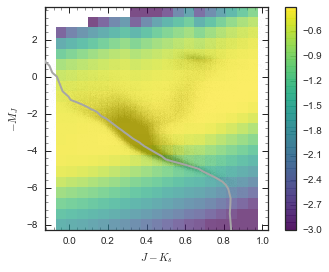

In [93]:
bovy_plot.bovy_dens2d(numpy.log10(evfs/(numpy.pi*0.25**2.*0.1)),origin='lower',cmap='viridis',
                     interpolation='nearest',zorder=1,
                     colorbar=True,vmin=-3.,vmax=numpy.log10(0.5),shrink=1.,alpha=0.7,
                     yrange=[-(mjs[0]-0.5*(mjs[1]-mjs[0])),
                            -(mjs[-1]+0.5*(mjs[1]-mjs[0]))],
                     xrange=[jks[0]-0.5*(jks[1]-jks[0]),
                             jks[-1]+0.5*(jks[1]-jks[0])],
                     xlabel=r'$J-K_s$',ylabel=r'$-M_J$')

def good_relplx(mj):
    out= numpy.empty_like(mj)
    out[mj > 5.]= 20.
    out[mj < 0.]= 10.
    out[(mj >= 0)*(mj <= 5.)]= 20.+2.*(mj[(mj >= 0)*(mj <= 5.)]-5.)
    return out
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
bovy_plot.bovy_plot((twomass['j_mag']-twomass['k_mag'])[good_plx_indx],
                    -(twomass['j_mag']-dm)[good_plx_indx],
                    'k,',rasterized=True,overplot=True,
                    xrange=[-0.5,1.5],yrange=[8.,-5.],alpha=0.01,zorder=0,
                    xlabel=r'$J-K_s$',ylabel=r'$M_J$',clabel=r'$\varpi/\sigma_\varpi$')
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s)*(not 'Y' in s)\
                      *(not '.5V' in s) for s in sp['SpT']],dtype='bool')
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],-sp['M_J'][sp_indx],
                    color='0.65',lw=2.,zorder=3,overplot=True)

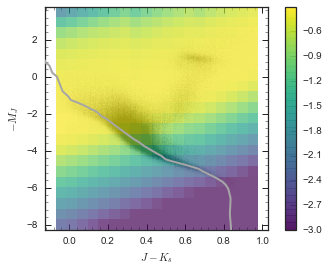

In [87]:
bovy_plot.bovy_dens2d(numpy.log10(evfs_wide/evfs_wide_2mass),origin='lower',cmap='viridis',
                     interpolation='nearest',zorder=1,alpha=0.7,
                     colorbar=True,vmin=-3.,vmax=numpy.log10(0.5),shrink=1.,
                     yrange=[-(mjs[0]-0.5*(mjs[1]-mjs[0])),
                            -(mjs[-1]+0.5*(mjs[1]-mjs[0]))],
                     xrange=[jks[0]-0.5*(jks[1]-jks[0]),
                             jks[-1]+0.5*(jks[1]-jks[0])],
                     xlabel=r'$J-K_s$',ylabel=r'$-M_J$')
bovy_plot.bovy_plot((twomass['j_mag']-twomass['k_mag'])[good_plx_indx],
                    -(twomass['j_mag']-dm)[good_plx_indx],
                    'k,',rasterized=True,overplot=True,
                    xrange=[-0.5,1.5],yrange=[8.,-5.],alpha=0.01,zorder=0,
                    xlabel=r'$J-K_s$',ylabel=r'$M_J$',clabel=r'$\varpi/\sigma_\varpi$')
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s)*(not 'Y' in s)\
                      *(not '.5V' in s) for s in sp['SpT']],dtype='bool')
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],-sp['M_J'][sp_indx],
                    color='0.65',lw=2.,zorder=3,overplot=True)

(8.0, -4.0)

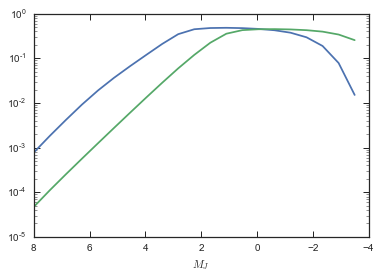

In [50]:
jkindx= numpy.argmin(numpy.fabs(jks-0.8))
semilogy(mjs,(evfs/evfs_2mass)[:,jkindx])
plot(mjs,(evfs_wide/evfs_wide_2mass)[:,jkindx])
xlabel(r'$M_J$')
xlim(8.,-4.)

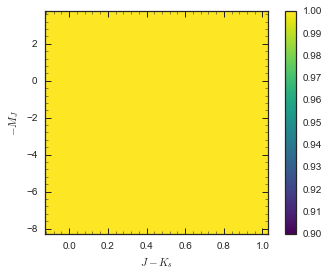

In [89]:
bovy_plot.bovy_dens2d(evfs_2mass/(numpy.pi*0.25**2.*0.1),origin='lower',
                      interpolation='nearest',cmap='viridis',colorbar=True,shrink=1.,
                      vmin=0.9,vmax=1.,
                     yrange=[-(mjs[0]-0.5*(mjs[1]-mjs[0])),
                            -(mjs[-1]+0.5*(mjs[1]-mjs[0]))],
                     xrange=[jks[0]-0.5*(jks[1]-jks[0]),
                             jks[-1]+0.5*(jks[1]-jks[0])],
                     xlabel=r'$J-K_s$',ylabel=r'$-M_J$')

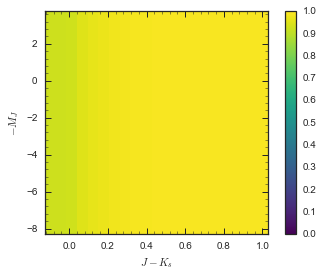

In [94]:
bovy_plot.bovy_dens2d(evfs_2mass/(numpy.pi*0.25**2.*0.1),origin='lower',
                      interpolation='nearest',cmap='viridis',colorbar=True,shrink=1.,
                      vmin=0.,vmax=1.,
                     yrange=[-(mjs[0]-0.5*(mjs[1]-mjs[0])),
                            -(mjs[-1]+0.5*(mjs[1]-mjs[0]))],
                     xrange=[jks[0]-0.5*(jks[1]-jks[0]),
                             jks[-1]+0.5*(jks[1]-jks[0])],
                     xlabel=r'$J-K_s$',ylabel=r'$-M_J$')

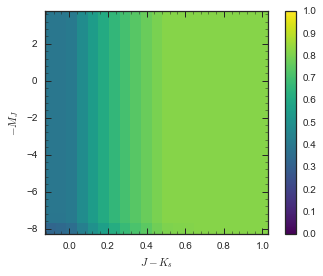

In [91]:
bovy_plot.bovy_dens2d(evfs_wide_2mass/(numpy.pi*0.5**2.*0.5),origin='lower',
                      interpolation='nearest',cmap='viridis',colorbar=True,shrink=1.,
                      vmin=0.,vmax=1.,
                     yrange=[-(mjs[0]-0.5*(mjs[1]-mjs[0])),
                            -(mjs[-1]+0.5*(mjs[1]-mjs[0]))],
                     xrange=[jks[0]-0.5*(jks[1]-jks[0]),
                             jks[-1]+0.5*(jks[1]-jks[0])],
                     xlabel=r'$J-K_s$',ylabel=r'$-M_J$')

In [101]:
5.*numpy.log10(0.5)+10.+8

16.890756251918219

In [104]:
mjs= numpy.linspace(8.,-3.5,21)
JK= 0.8
tvol_func1= lambda x,y,z: cyl_vol_func(x,y,z,xymax=2.,zmin=-1.,zmax=1.,use_cosh=0.15)
ndists= 1001
evfs= numpy.empty_like(mjs)
evfs_2mass= numpy.empty_like(mjs)
for ii, mj in tqdm.tqdm(enumerate(mjs)):
    evfs[ii]= tesf.volume(tvol_func1,MJ=mj,JK=JK,ndists=ndists,xyz=True)
    evfs_2mass[ii]= tesf_uniform.volume(lambda x,y,z: twomass_selfunc(x,y,z,mj,JK)*tvol_func1(x,y,z),
                                 ndists=ndists,xyz=True)


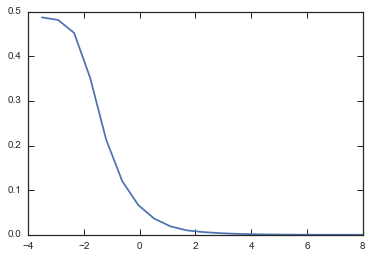

In [105]:
plot(mjs,evfs/evfs_2mass)

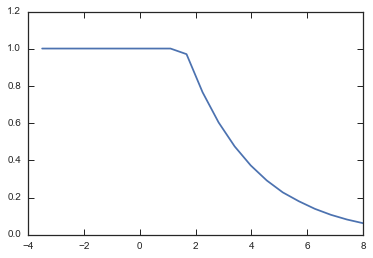

In [113]:
from scipy import integrate
plot(mjs,evfs_2mass/(numpy.pi*4.*integrate.quad(lambda x: 1./numpy.cosh(x/2./0.15)**2.,-1.,1.)[0]))